In [4]:
pip install selenium

  Using cached selenium-4.15.2-py3-none-any.whl (10.2 MB)
  Using cached trio-0.23.1-py3-none-any.whl (448 kB)
  Using cached trio_websocket-0.11.1-py3-none-any.whl (17 kB)
  Using cached sortedcontainers-2.4.0-py2.py3-none-any.whl (29 kB)
  Using cached outcome-1.3.0.post0-py2.py3-none-any.whl (10 kB)
  Using cached wsproto-1.2.0-py3-none-any.whl (24 kB)
  Using cached h11-0.14.0-py3-none-any.whl (58 kB)
Note: you may need to restart the kernel to use updated packages.


In [47]:
#import libraries
import requests
from bs4 import BeautifulSoup
import lxml
import re
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
import json
import numpy as np

In [44]:
#Read Andrew's IMDB data
df = pd.read_csv('Prophet1.csv', index_col = 0)
df['Name'] = df_movie.index
df_movie = pd.read_csv('Prophet1.csv', index_col = 0)
df_movie['Name'] = df_movie.index
df_movie.head()

,IMDB Ratings,IMDB Score,Content Rating,Date Released,year,month,day of the week,Genres,Genre A,Genre B,...,Writer 3,Runtime,Nominations,Awards,Estimated Budget,Budget Currency,Gross Revenue US&Canada USD,Opening Weekend Revenue US&Canada USD,Gross Revenue Worldwide USD,Name
Name,,,,,,,,,,,,,,,,,,,,,
Avatar: The Way of Water,469417,7.6,PG,2022-12-16,2022,12,4,['Action' 'Adventure' 'Fantasy'],Action,Adventure,...,Amanda Silver,192,135,65,350000000,$,684075767,134100226,2320250281,Avatar: The Way of Water
Puss in Boots: The Last Wish,161291,7.8,PG,2022-12-21,2022,12,2,['Animation' 'Adventure' 'Comedy'],Animation,Adventure,...,Tom Wheeler,102,56,5,90000000,$,185535345,12429515,481080374,Puss in Boots: The Last Wish
Babylon,153248,7.1,18A,2022-12-23,2022,12,4,['Comedy' 'Drama' 'History'],Comedy,Drama,...,none,189,146,43,110000000,$,15351455,3603368,63351455,Babylon
A Man Called Otto,141943,7.5,G,2023-01-13,2023,1,4,['Comedy' 'Drama'],Comedy,Drama,...,David Magee,126,8,0,50000000,$,64267657,56257,113190218,A Man Called Otto
M3GAN,132495,6.4,14A,2023-01-06,2023,1,4,['Horror' 'Sci-Fi' 'Thriller'],Horror,Sci-Fi,...,none,102,2,1,12000000,$,95043350,30429860,179973454,M3GAN


In [117]:
for i, idx in enumerate(df_movie.index):
    name = str(df_movie.loc[idx]['Name'])  # Convert to string if not already a string
    pattern = re.compile(r'[^A-Za-z0-9 ]+', re.UNICODE)
    name = re.sub(pattern, '', unidecode(name)).replace(' ', '_').lower()
    typ = 'm'
    year = df_movie.loc[idx]['year']
    
    # Construct URLs
    URL = f'https://www.rottentomatoes.com/{typ}/{name}/'
    URL2 = f'https://www.rottentomatoes.com/{typ}/{name}_{year}/'
    
    print(f"Processing: {URL}")
    
    # Fetch content from URL
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')
    section = soup.find('script', {'id': 'scoreDetails'})

    #Append year for RT movies with duplicate names
    print(f"Processing: {URL2}")
    page2 = requests.get(URL2)
    soup2 = BeautifulSoup(page2.content, 'html.parser')
    section2 = soup2.find('script', {'id': 'scoreDetails'})
    
    if section is None or (section2 is not None and len(section2.string) > len(section.string)):
        selected_section = section2
    else:
        selected_section = section
    
    if selected_section is None: # Error handling for titles that cannot be found
        print(f'Could not scrape data for this movie: {df_movie.loc[idx]["Name"]}')
        print(f'Progress: {round((i+1)/len(df_movie) * 100, 2)}%')
    
    else:

        script_content = selected_section.string

        if script_content:
            data = json.loads(script_content)

            audience_score = data['modal']['audienceScoreAll'].get('averageRating', 'N/A')
            audience_count = data['modal']['audienceScoreAll'].get('ratingCount', 'N/A')
            tomato_score = data['modal']['tomatometerScoreAll'].get('averageRating', 'N/A')
            tomato_count = data['modal']['tomatometerScoreAll'].get('ratingCount', 'N/A')

            df_movie.loc[idx, 'RT_audience_score'] = audience_score
            df_movie.loc[idx, 'RT_tomatometer_score'] = tomato_score
            df_movie.loc[idx, 'RT_audience_#reviews'] = audience_count
            df_movie.loc[idx, 'RT_tomatometer_#reviews'] = tomato_count

            print(df_movie.loc[idx, ['RT_audience_score', 'RT_tomatometer_score', 'RT_audience_#reviews','RT_tomatometer_#reviews']])
            print(f'Progress: {round((i+1)/len(df_movie) * 100, 2)}%')
        else:
            print('Script content is empty')

df_movie.to_csv('movie_data_with_rt2.csv', index=False)  # Save the updated DataFrame to a CSV file

Processing: https://www.rottentomatoes.com/m/avatar_the_way_of_water/
Processing: https://www.rottentomatoes.com/m/avatar_the_way_of_water_2022/
RT_audience_score              4.3
RT_tomatometer_score          7.10
RT_audience_#reviews       48195.0
RT_tomatometer_#reviews      448.0
Name: Avatar: The Way of Water, dtype: object
Progress: 0.04%
Processing: https://www.rottentomatoes.com/m/puss_in_boots_the_last_wish/
Processing: https://www.rottentomatoes.com/m/puss_in_boots_the_last_wish_2022/
RT_audience_score              4.7
RT_tomatometer_score          7.60
RT_audience_#reviews       16575.0
RT_tomatometer_#reviews      192.0
Name: Puss in Boots: The Last Wish, dtype: object
Progress: 0.08%
Processing: https://www.rottentomatoes.com/m/babylon/
Processing: https://www.rottentomatoes.com/m/babylon_2022/
RT_audience_score             3.7
RT_tomatometer_score         6.40
RT_audience_#reviews       6999.0
RT_tomatometer_#reviews     358.0
Name: Babylon, dtype: object
Progress: 0.12%


In [121]:
len(df_movie[df_movie['RT_tomatometer_score'].isnull()])

362

In [122]:
362/2480

0.14596774193548387

In [52]:
df_movie.columns

Index(['IMDB Ratings', 'IMDB Score', 'Content Rating', 'Date Released', 'year',
       'month', 'day of the week', 'Genres', 'Genre A', 'Genre B', 'Genre C',
       'Keywords', 'Keyword 1', 'Keyword 2', 'Keyword 3', 'Stars', 'Star 1',
       'Star 2', 'Star 3', 'Directors', 'Director 1', 'Director 2',
       'Director 3', 'Writers', 'Writer 1', 'Writer 2', 'Writer 3', 'Runtime',
       'Nominations', 'Awards', 'Estimated Budget', 'Budget Currency',
       'Gross Revenue US&Canada USD', 'Opening Weekend Revenue US&Canada USD',
       'Gross Revenue Worldwide USD', 'Name',
       'rottentomatoes_tomatometer_score', 'rottentomatoes_audience_#reviews',
       'rottentomatoes_tomatometer_#reviews', 'RT_audience_score',
       'RT_tomatometer_score', 'RT_audience_#reviews',
       'RT_tomatometer_#reviews'],
      dtype='object')

In [55]:
#Start Here if csv export is complete

df_movie = pd.read_csv('movie_data_with_rt3.csv')
df_movie.index = df_movie['Name']

#Convert audience score from 5 star scale to out of 10 score
#df_movie['RT_audience_score'] = df_movie['RT_audience_score']*2

#Remove rows where RT_audience score is missing by first changing N/A to null
df_movie['RT_audience_score'].replace('N/A', np.nan, inplace=True)

# Drop rows where 'RT_audience_score' is null
df_movie.dropna(subset=['RT_audience_score'], inplace=True)

## Exploratory Data Analysis

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
# Count missing values in each column
missing_values = df_movie.isnull().sum()

# Display the count of missing values for each column
print(missing_values)

IMDB Ratings                              0
IMDB Score                                0
Content Rating                            0
Date Released                             0
year                                      0
month                                     0
day of the week                           0
Genres                                    0
Genre A                                   0
Genre B                                   0
Genre C                                   0
Keywords                                  0
Keyword 1                                 0
Keyword 2                                 0
Keyword 3                                 0
Stars                                     0
Star 1                                    0
Star 2                                    0
Star 3                                    0
Directors                                 0
Director 1                                0
Director 2                                0
Director 3                      

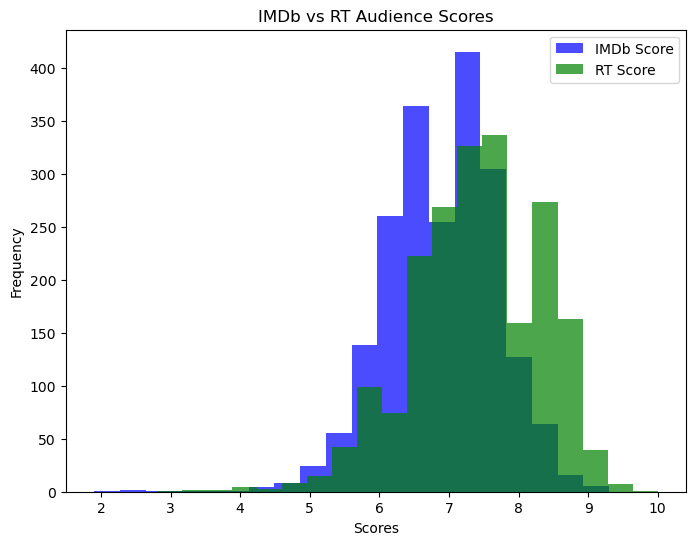

In [57]:
# Assuming df contains IMDb and RT scores in columns 'IMDB Score' and 'RT_audience_score'
plt.figure(figsize=(8, 6))

# Plot IMDb scores
plt.hist(df_movie['IMDB Score'], bins=20, alpha=0.7, label='IMDb Score', color='blue')

# Plot RT scores
plt.hist(df_movie['RT_audience_score'], bins=20, alpha=0.7, label='RT Score', color='green')

plt.title('IMDb vs RT Audience Scores')
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.legend()
plt.show()